In [ ]:
# only run this in google colab to upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# only run this in google colab to unzip data
!unzip data.zip

In [2]:
# adopted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np

plt.ion()   # interactive mode

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
# Data Preprocessing
train_transform =  transforms.Compose([
        # image resizing + data augmentation
        transforms.RandomResizedCrop(224),         
        # data augmentation
        transforms.RandomHorizontalFlip(),         
        # convert image to PyTorch Tensor
        transforms.ToTensor(),    
        # z score normalization
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])

val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
data_dir = 'data/hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [31]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
# load and print the pretrained model
model_ft = models.resnet18(pretrained=True)
# print(model_ft)

In [33]:
# Change the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

In [34]:
# move the model to GPU if available
model_ft = model_ft.to(device)

In [35]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01)

In [36]:
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
epochs = 100
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        out = model_ft(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            out = model_ft(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
    
    scheduler.step()
    

Epoch 0
training loss: 0.64080077
validation loss: 0.36596727
Epoch 1
training loss: 0.59456068
validation loss: 0.71627760


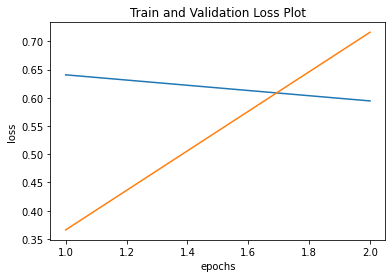

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [16]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [25]:
test_predictions = np.empty((0,2))
test_gt = np.empty((2))
with torch.no_grad():
    for iteration, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = net(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)
        test_gt = np.append(test_gt, y_batch, 
                                     axis=0)
        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_gt)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_gt, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(test_gt, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(test_y, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_gt, test_predictions))



Predicted Class:
[0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0
 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1
 1 0 1]

Ground Truth:


NameError: name 'test_y' is not defined

In [7]:
import struct
import numpy as np
from scipy import signal as sg

sampling_rate = 44100                    ## Sampling Rate
freq = 440                               ## Frequency (in Hz)
samples = 44100                          ## Number of samples 
x = np.arange(samples)

####### sine wave ###########
y = 100*np.sin(2 * np.pi * freq * x / sampling_rate)

####### square wave ##########
# y = 100* sg.square(2 *np.pi * f *x / Fs )

####### square wave with Duty Cycle ##########
# y = 100* sg.square(2 *np.pi * f *x / Fs , duty = 0.8)

####### Sawtooth wave ########
# y = 100* sg.sawtooth(2 *np.pi * f *x / Fs )


f = open('test.wav','wb')
## Instructions to play test.wav on computer
## 1. Open as Signed 8-bit on Audacity - Watch Video at https://bit.ly/2YwmN9q for instructions
## 2. Or using SoX: play -t raw -r 44.1k -e signed -b 8 -c 1 test.wav

for i in y:
	f.write(struct.pack('b',int(i)))
f.close()

Just mono files


C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


SystemExit: 0

C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
